# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [252]:
#Import all the required libraries
import tensorflow as tf
from tensorflow import keras
import glob
from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.data.experimental import Counter
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import collections
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import string
from gtts import gTTS
from IPython import display

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [138]:
#Import the dataset and read the image into a seperate variable
images='datasets/flickr/Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


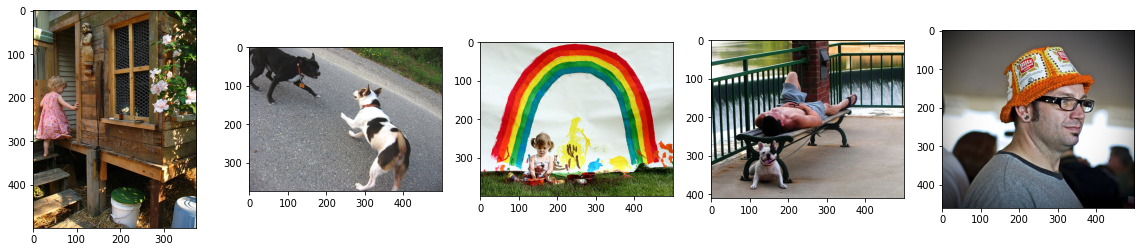

In [139]:
#Visualise both the images & text present in the dataset\
Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [140]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    text = pd.read_csv(filename)
    return text

text_file = 'datasets/flickr/captions.txt'
doc = load_doc(text_file)
doc[:300]

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
295,1077546505_a4f6c4daa9.jpg,A boy in blue shorts slides down a slide into ...
296,1077546505_a4f6c4daa9.jpg,A boy in blue swimming trunks slides down a ye...
297,1077546505_a4f6c4daa9.jpg,A boy rides down a slide into a small backyard...
298,1077546505_a4f6c4daa9.jpg,A boy sliding down a slide into a pool with co...


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [141]:
all_img_id= doc.iloc[:, 0]
all_img_vector= [images+'/']*40455
annotations= doc.iloc[:, 1]

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])
df['Path'] = df['Path'] + df['ID']
all_img_vector = df[['Path']]
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [142]:
#Create a list which contains all the captions
annotations=df.iloc[:, 2].values
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line]
    line = [word.translate(remove_punctuation) for word in line]
    line = [word for word in line if len(word)>1]
    line = [word for word in line if word.isalpha()]
    annotations[i]=  ' '.join(line)

# #add the <start> & <end> token to all those captions as well
annotations = [' <start> '+i+' <end> ' for i in annotations]

#Create a list which contains all the path to the images
all_img_path=list(df['Path'] + df['ID'])


print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [143]:
#Create the vocabulary & the counter for the captions
vocabulary= [word for line in annotations for word in line.split()]
val_count=collections.Counter(vocabulary)
val_count

Counter({'<start>': 40455,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         '<end>': 40455,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tricolored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
      

<start> :  40455
<end> :  40455
in :  18974
the :  18418
on :  10743
is :  9345
and :  8851
dog :  8136
with :  7765
man :  7265
of :  6713
two :  5638
white :  3940
black :  3832
boy :  3581
are :  3504
woman :  3402
girl :  3328
to :  3173
wearing :  3062
at :  2914
people :  2883
water :  2783
red :  2672
young :  2630
brown :  2563
an :  2432
his :  2357
blue :  2268
dogs :  2125


Text(0, 0.5, 'Counts')

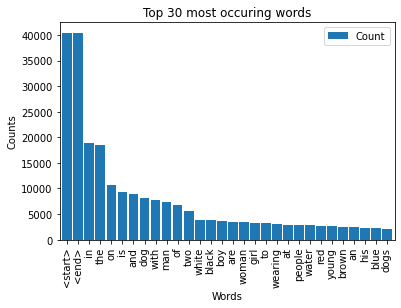

In [144]:
#Visualise the top 30 occuring words in the captions

#write your code here
for word, count in val_count.most_common(30):
    print(word, ": ", count)
    
lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.9)
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")

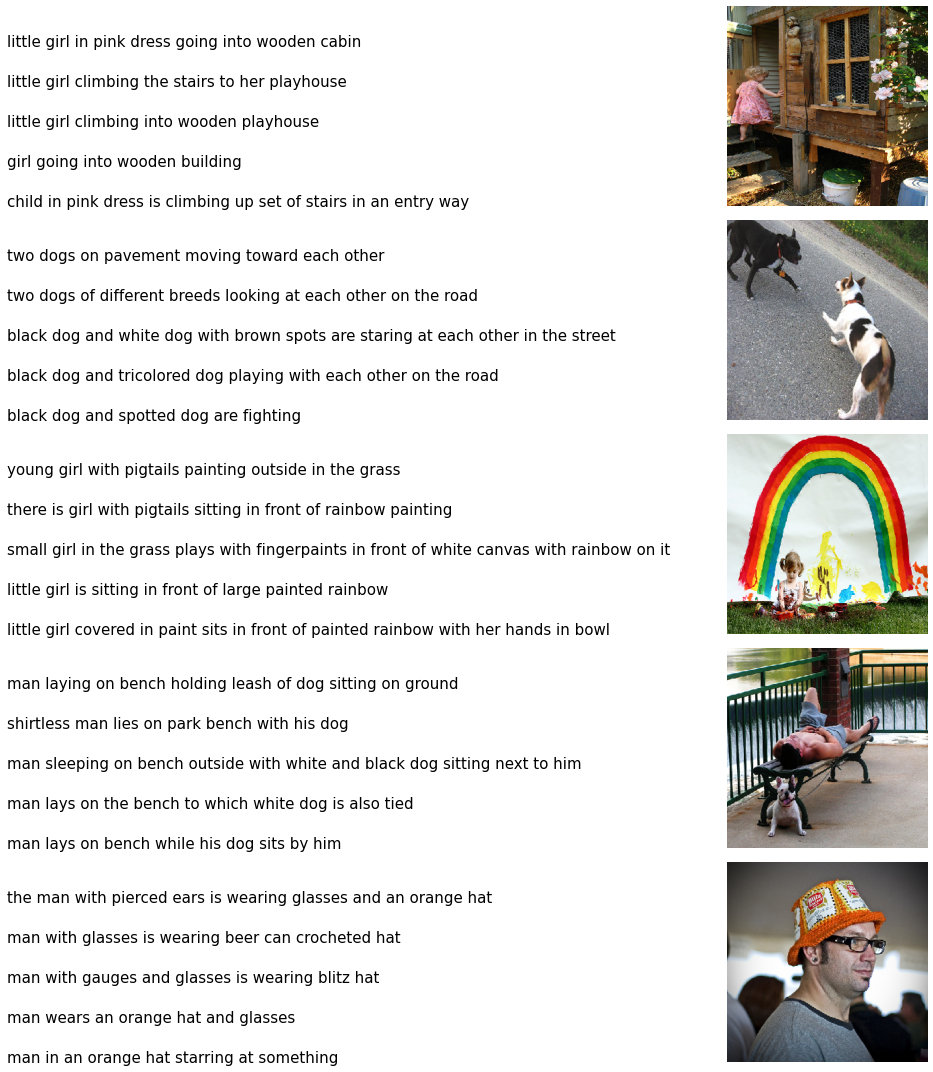

In [154]:
fig = plt.figure(figsize=(15,15))
count = 1
    
for Path in df[:25].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(5,2,count) 
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)    
    count+=1
    plt.tight_layout()

    ax = fig.add_subplot(5,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()

In [159]:
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))
annotations[0:5]

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


[' <start> child in pink dress is climbing up set of stairs in an entry way <end> ',
 ' <start> girl going into wooden building <end> ',
 ' <start> little girl climbing into wooden playhouse <end> ',
 ' <start> little girl climbing the stairs to her playhouse <end> ',
 ' <start> little girl in pink dress going into wooden cabin <end> ']

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [162]:
# create the tokenizer
top_voc = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower=True, char_level=False,
                                                  oov_token="UNK")
#your code here
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)


tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [163]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [169]:
# Create word-to-index and index-to-word mappings.
#your code here
word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word

In [170]:
train_seqs[:5]

[[2, 42, 4, 90, 169, 7, 119, 53, 394, 12, 391, 4, 28, 1, 692, 3],
 [2, 19, 313, 64, 193, 117, 3],
 [2, 40, 19, 119, 64, 193, 2423, 3],
 [2, 40, 19, 119, 5, 391, 20, 60, 2423, 3],
 [2, 40, 19, 4, 90, 169, 313, 64, 193, 2985, 3]]

<start> :  40455
<end> :  40455
in :  18974
the :  18418
on :  10743
is :  9345
and :  8851
dog :  8136
with :  7765
man :  7265
of :  6713
two :  5638
white :  3940
black :  3832
boy :  3581
are :  3504
woman :  3402
girl :  3328
to :  3173
wearing :  3062
at :  2914
people :  2883
water :  2783
red :  2672
young :  2630
brown :  2563
an :  2432
his :  2357
blue :  2268
dogs :  2125


/tmp/ipykernel_302/2808235747.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


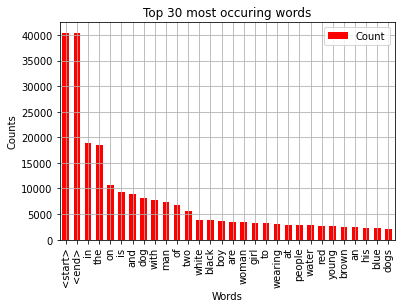

In [171]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
#your code here
tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.grid(b=None)

In [174]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
sequences = tokenizer.texts_to_sequences(annotations)
maxlen = max([len(i) for i in sequences])

cap_vector = pad_sequences(train_seqs, maxlen=maxlen, padding='post', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 34)


In [178]:
cap_vector[:2]

array([[  2,  42,   4,  90, 169,   7, 119,  53, 394,  12, 391,   4,  28,
          1, 692,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  19, 313,  64, 193, 117,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [180]:
annotations[:2]

[' <start> child in pink dress is climbing up set of stairs in an entry way <end> ',
 ' <start> girl going into wooden building <end> ']

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [173]:
#write your code here to create the dataset consisting of image paths
tf.keras.backend.image_data_format() 

'channels_last'

In [183]:
#write your code here for creating the function. This function should return images & their path
IMAGE_SHAPE= (299, 299)
def preprocess_images(image_path):

    img = tf.io.read_file(image_path,name=None)
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    return img, image_path

In [185]:
#write your code here for applying the function to the image path dataset, such that the transformeinputataset should contain images & their path
training_list = sorted(set(all_img_vector.iloc[:,0].values))
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)
New_Image_Data = New_Image_Data.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

In [187]:
New_Image_Data

<BatchDataset shapes: ((None, 299, 299, None), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [188]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = keras.Model(new_input, hidden_layer)

In [189]:
image_features_extract_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_188 (Conv2D)            (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_188 (Batch  (None, None, None,   96         ['conv2d_188[0][0]']             
 Normalization)                 32)                                                         

In [190]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_dict={}
for image, image_path in tqdm(New_Image_Data):
    features_for_batch = image_features_extract_model(image)
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3]))
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()

100%|██████████| 127/127 [00:20<00:00,  6.13it/s]


In [200]:
print('features_for_batch.shape:', features_for_batch.shape)
print('features_for_batch_flattened.shape:', features_for_batch_flattened.shape)
print('batch_feat.shape:', batch_feat.shape)

features_for_batch.shape: (27, 8, 8, 2048)
features_for_batch_flattened.shape: (27, 64, 2048)
batch_feat.shape: (64, 2048)


In [202]:
import more_itertools
more_itertools.take(5, image_features_dict.items())

[('datasets/flickr/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16897164],
         [0.        , 0.        , 1.0098951 , ..., 0.        , 0.        ,
          0.05999926],
         ...,
         [0.        , 0.        , 2.037957  , ..., 1.2063352 , 0.        ,
          1.9916674 ],
         [0.        , 0.        , 0.9089928 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2563984 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('datasets/flickr/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.6657375 , 0.462695  , ..., 0.        , 0.        ,
          3.3323247 ],
         [0.        , 1.2269326 , 0.        , ..., 0.        , 0.25074652,
          3.3297448 ],
         [1.2845701 , 1.5145215 , 0.        , ..., 0.46673563, 0.36348096,
 

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [203]:
#write your code here
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [196]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [198]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image,captions):
    img_tensor = image_features_dict[image.decode('utf-8')]
    return img_tensor,captions

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [204]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64

def gen_dataset(images_data, captions_data):
    
    # Creating a Dataset using tf.data.Dataset.from_tensor_slice 
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
    # Prefetch function is used to prepare later elements while the current element is being processed.
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 

    return dataset

In [205]:
train_dataset=gen_dataset(path_train.iloc[:, 0].values,cap_train)
test_dataset=gen_dataset(path_test.iloc[:, 0].values,cap_test)

In [83]:
path_train.iloc[:, 0].values[0]

'datasets/flickr/Images/359082432_c1fd5aa2d6.jpg'

In [206]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 34)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [85]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train.iloc[:, 0].values) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test.iloc[:, 0].values)#len(total test images) // BATCH_SIZE
max_length = maxlen
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

### Encoder

In [207]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [208]:
encoder=Encoder(embedding_dim)

### Attention model

In [209]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [211]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [212]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [91]:
features=encoder(sample_img_batch)

hidden = decoder.reset_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [213]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE)

In [215]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [216]:
checkpoint_path = "model3"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [217]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [218]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)
        
        for t in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:, t], predictions)
            dec_input = tf.expand_dims(target[:, t], 1) #Techaer forcing
    avg_loss = (loss / int(target.shape[1]))
    
    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables)
    
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [222]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: 
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:, t], predictions)
            dec_input = tf.expand_dims(target[:, t], 1) # using teacher forcing
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables)
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

In [223]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [224]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [01:55<26:56, 115.43s/it]

For epoch: 1, the train loss is 1.087, & test loss is 0.017
Time taken for 1 epoch 115.26830434799194 sec

Test loss has been reduced from 100.000 to 0.017


 13%|█▎        | 2/15 [02:57<18:14, 84.21s/it] 

For epoch: 2, the train loss is 0.978, & test loss is 0.015
Time taken for 1 epoch 62.23104548454285 sec

Test loss has been reduced from 0.017 to 0.015


 20%|██        | 3/15 [03:59<14:48, 74.01s/it]

For epoch: 3, the train loss is 0.907, & test loss is 0.014
Time taken for 1 epoch 61.72163438796997 sec

Test loss has been reduced from 0.015 to 0.014


 27%|██▋       | 4/15 [05:01<12:40, 69.13s/it]

For epoch: 4, the train loss is 0.849, & test loss is 0.013
Time taken for 1 epoch 61.49496388435364 sec

Test loss has been reduced from 0.014 to 0.013


 33%|███▎      | 5/15 [06:03<11:05, 66.52s/it]

For epoch: 5, the train loss is 0.799, & test loss is 0.012
Time taken for 1 epoch 61.75958490371704 sec

Test loss has been reduced from 0.013 to 0.012


 40%|████      | 6/15 [07:06<09:48, 65.37s/it]

For epoch: 6, the train loss is 0.754, & test loss is 0.012
Time taken for 1 epoch 62.97983932495117 sec

Test loss has been reduced from 0.012 to 0.012


 47%|████▋     | 7/15 [08:09<08:35, 64.50s/it]

For epoch: 7, the train loss is 0.713, & test loss is 0.011
Time taken for 1 epoch 62.52385067939758 sec

Test loss has been reduced from 0.012 to 0.011


 53%|█████▎    | 8/15 [09:11<07:27, 63.90s/it]

For epoch: 8, the train loss is 0.673, & test loss is 0.010
Time taken for 1 epoch 62.47270321846008 sec

Test loss has been reduced from 0.011 to 0.010


 60%|██████    | 9/15 [10:13<06:19, 63.32s/it]

For epoch: 9, the train loss is 0.635, & test loss is 0.010
Time taken for 1 epoch 61.85709261894226 sec

Test loss has been reduced from 0.010 to 0.010


 67%|██████▋   | 10/15 [11:17<05:17, 63.47s/it]

For epoch: 10, the train loss is 0.602, & test loss is 0.009
Time taken for 1 epoch 63.6642701625824 sec

Test loss has been reduced from 0.010 to 0.009


 73%|███████▎  | 11/15 [12:20<04:13, 63.42s/it]

For epoch: 11, the train loss is 0.570, & test loss is 0.009
Time taken for 1 epoch 63.16980242729187 sec

Test loss has been reduced from 0.009 to 0.009


 80%|████████  | 12/15 [13:24<03:10, 63.35s/it]

For epoch: 12, the train loss is 0.542, & test loss is 0.008
Time taken for 1 epoch 63.04416251182556 sec

Test loss has been reduced from 0.009 to 0.008


 87%|████████▋ | 13/15 [14:26<02:05, 62.95s/it]

For epoch: 13, the train loss is 0.515, & test loss is 0.008
Time taken for 1 epoch 61.870184659957886 sec

Test loss has been reduced from 0.008 to 0.008


 93%|█████████▎| 14/15 [15:28<01:02, 62.68s/it]

For epoch: 14, the train loss is 0.490, & test loss is 0.008
Time taken for 1 epoch 61.9074342250824 sec

Test loss has been reduced from 0.008 to 0.008


100%|██████████| 15/15 [16:31<00:00, 66.08s/it]

For epoch: 15, the train loss is 0.468, & test loss is 0.007
Time taken for 1 epoch 62.998018980026245 sec

Test loss has been reduced from 0.008 to 0.007


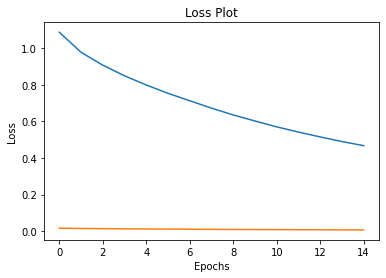

In [225]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [243]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
    return final_caption



In [238]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [239]:
from nltk.translate.bleu_score import sentence_bleu

In [240]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [241]:
# cap_test
img_test=path_test.iloc[:, 0].values
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
# cap_test[3606]
test_image

'datasets/flickr/Images/405961988_fcfe97f31e.jpg'

In [ ]:
# preprocess_images_function(test_image)

BELU score: 38.969252673404824
Real Caption: little boy is running on the round playing with little girl
Prediction Caption: young boy is running on the beach


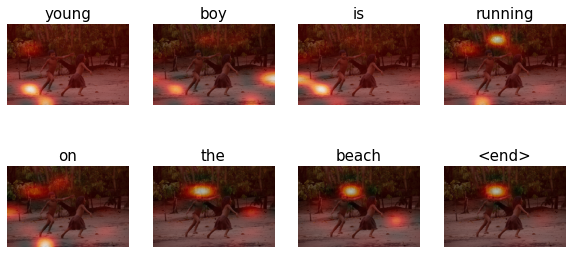

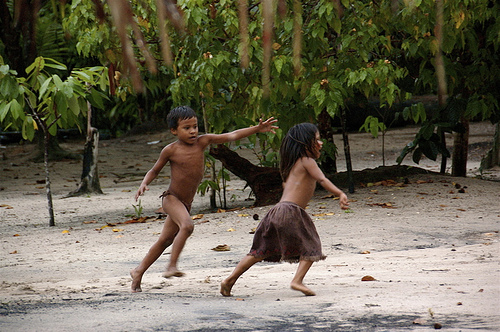

In [258]:
img_test=path_test.iloc[:, 0].values
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")
print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [256]:
#modifying the given code as function to run it several times by changing weights
def predicted_caption_audio(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):

#     cap_test=cap_test.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]
    #test_image = 'Flickr8K/Images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    speech = gTTS(pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))
    
    return test_image

BELU score: 0
Real Caption: person skiing downhill
Prediction Caption: skier going down snowy hill


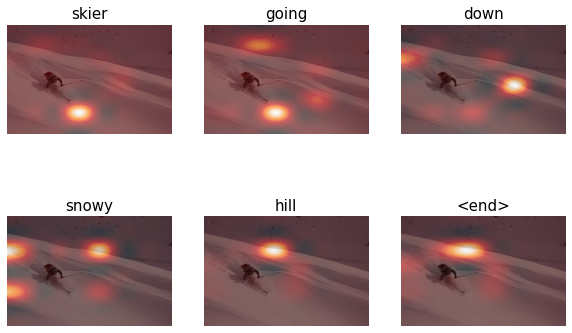

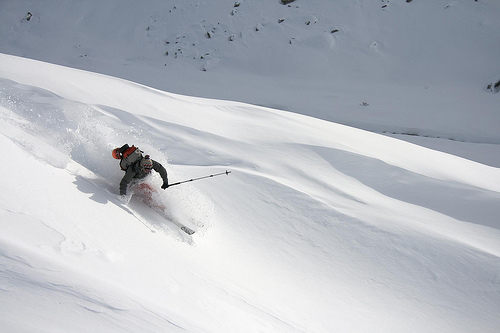

In [257]:
test_image=predicted_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

Prediction Caption: white bird with large beak


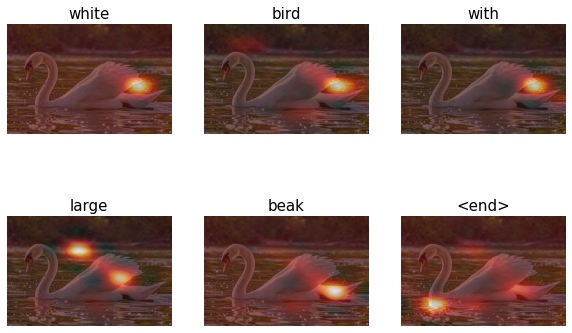

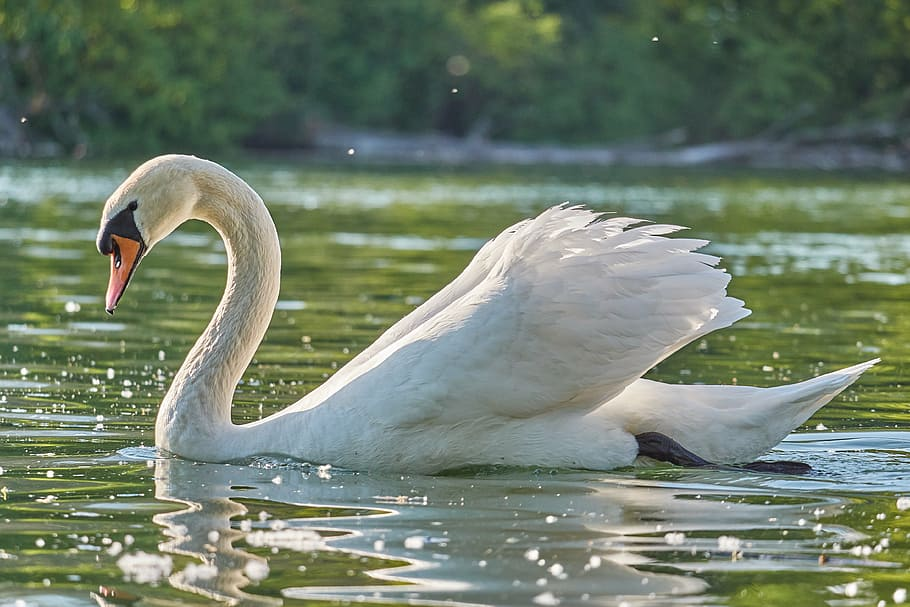

In [270]:
#Some images downloaded from google
img_test=path_test.iloc[:, 0].values
rid = np.random.randint(0, len(img_test))
test_image = 'swan-water-swim-white.jpg'

result, attention_plot,pred_test = evaluate(test_image)

pred_caption=' '.join(result).rsplit(' ', 1)[0]

print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)